# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python

In [2]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime

from pandasql import sqldf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [3]:
con = mysql.connector.connect(user='root', password='12345678',
                              host='127.0.0.1',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [4]:
cursor = con.cursor()

sql = """
SELECT 
    MAX(e.hire_date)
    ,MIN(e.hire_date)
FROM employees e
"""
cursor.execute(sql)
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП. 

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [5]:
con = mysql.connector.connect(user='root', password='12345678',
                              host='127.0.0.1',
                              database='employees')

In [6]:
cursor = con.cursor()

sql_2 = """
SELECT 
    DISTINCT(emp_no) emp_no
    ,MAX(salary) salary
    ,cast(MAX(s.from_date) as datetime) from_date
    ,MAX(s.to_date)to_date
FROM salaries s
GROUP BY emp_no
"""
#cursor.execute(sql)

In [7]:
res = pd.read_sql(sql_2, con)

cursor.execute(sql_2)

field_names = [i[0] for i in cursor.description]
display(field_names)

display(res.shape)
display(res.head(3))

/var/folders/wk/fmxhg7nx4l16n4c480_hhp740000gn/T/ipykernel_8279/171737678.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  res = pd.read_sql(sql_2, con)


['emp_no', 'salary', 'from_date', 'to_date']

(300024, 4)

,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43699,2001-12-01,9999-01-01


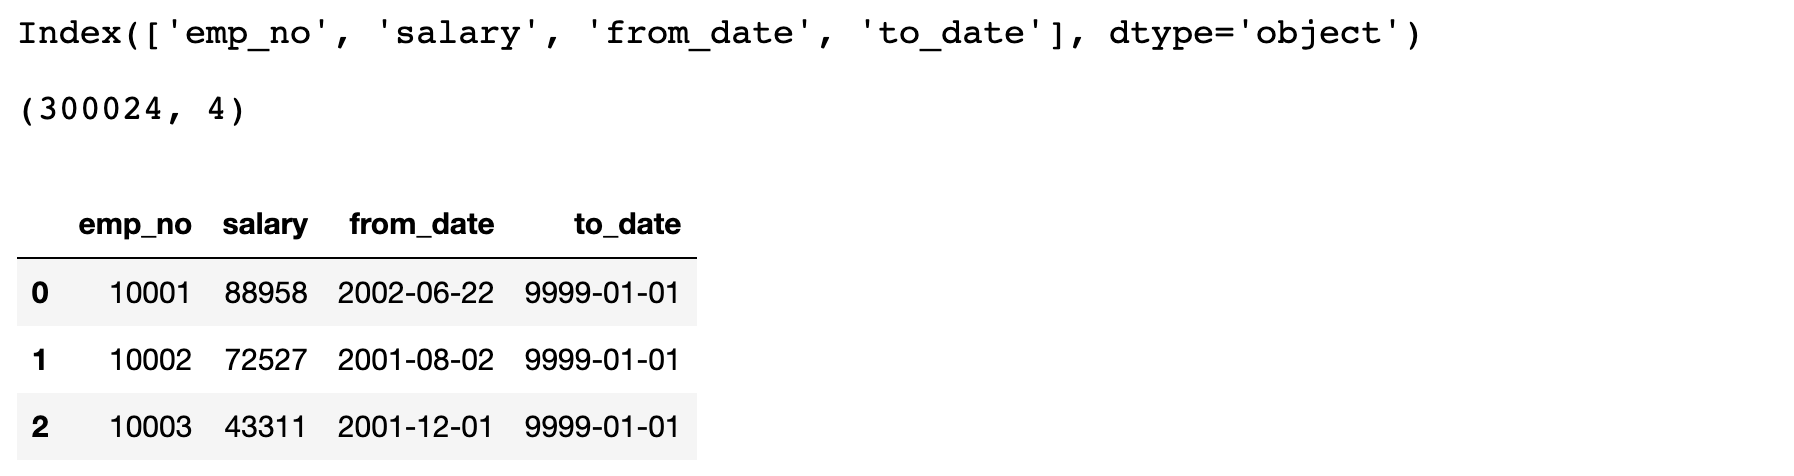

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [8]:
res.dtypes

emp_no                int64
salary                int64
from_date    datetime64[ns]
to_date              object
dtype: object

In [9]:
# Вийшло зробити тільки таким чином((( Спробувала перетворити колонку to_date на datetime64 спочатку в sql з допомогою CAST,
# потим тут за допомогою pd.to_datetime, але саме дата 9999-01-01 виходить за рамки максимальної для datetime64[ns] і тому
# не вийшло змінити тип, а замінити всі дати 9999-01-01 на pd.NaT додати до pd.to_datetime аргумент: errors='coerce' не хотіла
# т.я. можуть бути випадки, коли такі великі дати необхідно збереги, а не замінувати на NaT.

res['to_date'] = pd.PeriodIndex([pd.Period(d, freq="D") for d in res.to_date])

print(f"""В утвореній вибірці в змінній res значень to_date
,які рівні '9999-01-01' - {res[res.to_date == '9999-01-01'].to_date.count()} шт,
,які НЕ рівні - {res[res.to_date != '9999-01-01'].to_date.count()} шт""")

В утвореній вибірці в змінній res значень to_date
,які рівні '9999-01-01' - 240124 шт,
,які НЕ рівні - 59900 шт


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

''

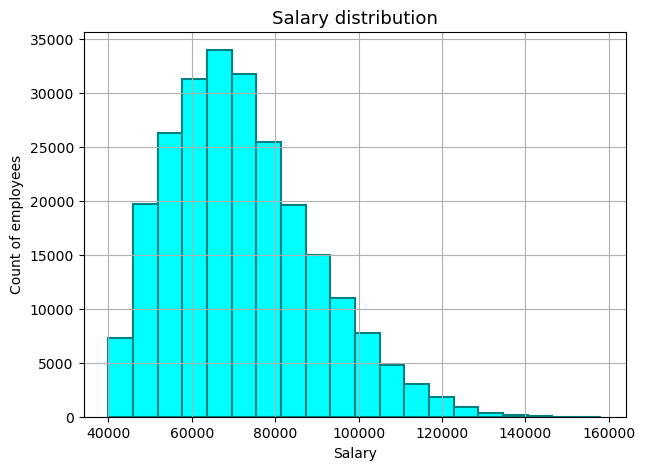

In [10]:
res[res.to_date == '9999-01-01'].salary.hist(figsize=(7,5), bins = 20, color='aqua', ec="teal", lw=1.5)

plt.xlabel('Salary') 
plt.ylabel('Count of employees')
plt.title("Salary distribution", fontsize=13)
;

7.Виведіть кількість співробітників за роком, в який вони були найняті (`hire_date`) використовуючи `pandas.read_sql`. Запишіть результат в змінну `df` та виведіть значення змінної на екран.

In [12]:
con = mysql.connector.connect(user='root', password='12345678',
                              host='127.0.0.1',
                              database='employees')

In [13]:
df = pd.read_sql(f"""SELECT 
                            YEAR(hire_date) AS hire_year
                            ,COUNT(emp_no)  AS emp_num
                       FROM employees
                       GROUP BY YEAR(hire_date)
                       ORDER BY hire_year ASC;""", con)
df

/var/folders/wk/fmxhg7nx4l16n4c480_hhp740000gn/T/ipykernel_8279/2725885445.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"""SELECT


,hire_year,emp_num
0,1985,35316
1,1986,36150
2,1987,33501
3,1988,31436
4,1989,28394
5,1990,25610
6,1991,22568
7,1992,20402
8,1993,17772
9,1994,14835


Очікуваний результат:

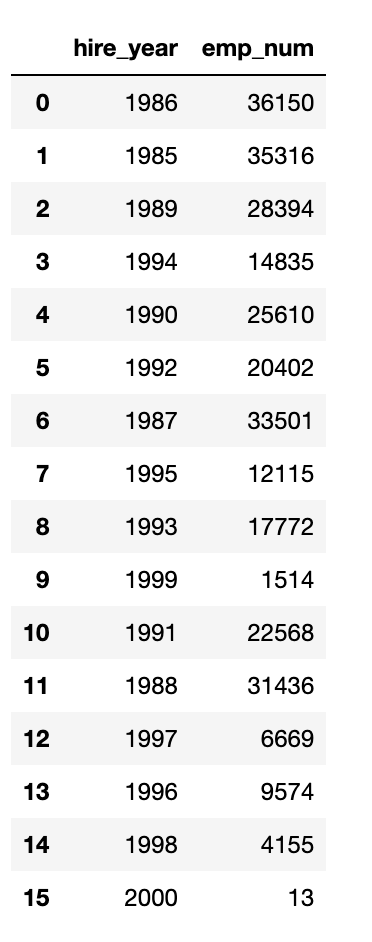

8.Виведіть лінійний графік залежності кількості найманих співробітників від року найму. Ми ж не просто так дані з бази дістали :)
Перейменувати назви колонок датафрейму можна або методами pandas, або в sql запиті в попередньому завданні. Також, аби графік вийшов правильний, треба відсортувати роки за зростанням. І це також можна зробити аби в pandas, або в SQL.

''

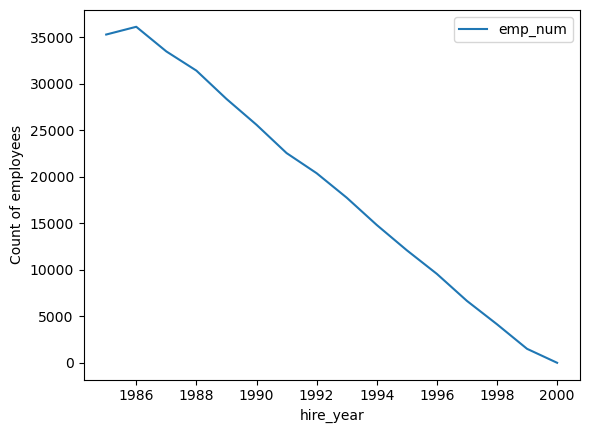

In [14]:
df.plot(x = 'hire_year', y = 'emp_num')
plt.ylabel('Count of employees') 
;

Очікуваний результат:

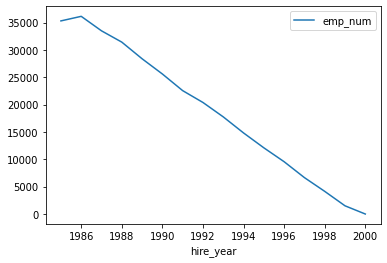

9.З допомогою SQL для робітників позиції `Engineer`, які вже не працюють в компанії (тобто у них є значення to_date, яке заповнено НЕ значенням за замовчанням) знайдіть кількість повних років перебування на позиції. Позиція зберігається в колонці `title` в таблиці `titles`. Кількість років перебування на позиції можна отримати наприклад з використанням функції `timestampdiff`. Ознайомтесь з її використанням в [документації](https://dev.mysql.com/doc/refman/8.0/en/date-and-time-functions.html#function_timestampdiff).

Результат запишіть в змінну `df_years` та виведіть цю змінну на екран.

In [15]:
df_years = pd.read_sql(f"""SELECT 
                                TIMESTAMPDIFF(YEAR, from_date, to_date) AS duration
                                ,from_date
                                ,to_date
                           FROM titles
                           WHERE LOWER(title) = 'engineer'
                                AND to_date != '9999-01-01' """, con)
df_years

/var/folders/wk/fmxhg7nx4l16n4c480_hhp740000gn/T/ipykernel_8279/2189434921.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_years = pd.read_sql(f"""SELECT


,duration,from_date,to_date
0,9,1986-12-01,1995-12-01
1,5,1990-02-18,1995-02-18
2,8,1992-12-18,2000-12-18
3,8,1987-04-03,1995-04-03
4,5,1995-03-20,2001-03-19
...,...,...,...
84015,9,1989-11-23,1998-11-23
84016,5,1989-07-30,1994-07-30
84017,0,1993-02-22,1993-10-27
84018,6,1996-05-13,2002-05-13


Очікуваний результат:

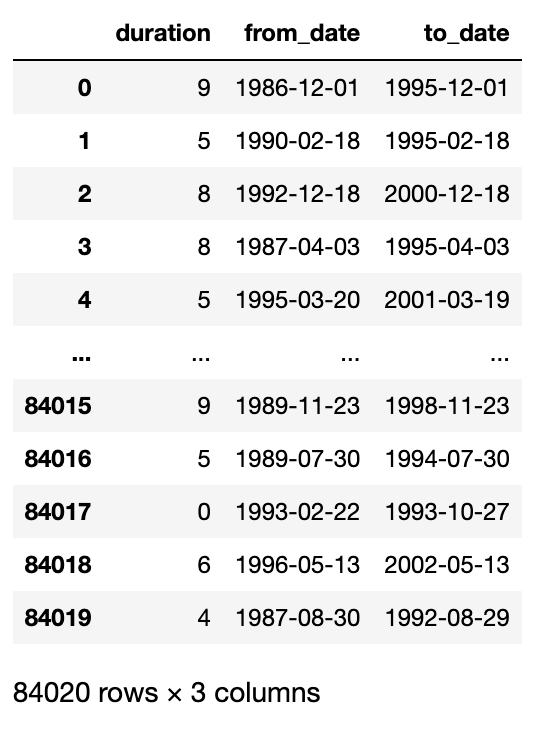

10.Використовуючи дані в  `df_years`, побудуйте гістограму кількості років, протягом яких люди з назвою позиції `Engineer` перебували на позиції. Не забудьте дати назву діаграмі, а також підписати вісі.

''

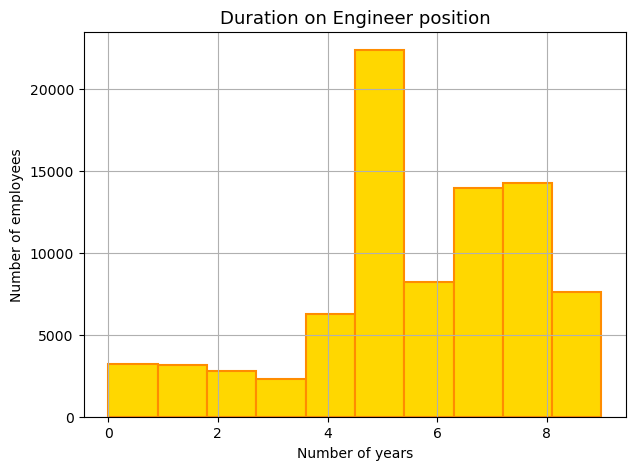

In [16]:
df_years.duration.hist(figsize=(7,5), bins = 10, color='gold', ec="darkorange", lw=1.5)

plt.xlabel('Number of years') 
plt.ylabel('Number of employees')
plt.title("Duration on Engineer position", fontsize=13)
;

Очікуваний результат:

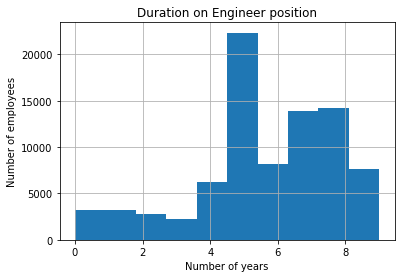

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [17]:
con.close()